# Plot benchmark results
In this script, we ultilized [scib-metrics](https://github.com/YosefLab/scib-metrics/tree/main) to bechmark and select optimal benchmarking results.

In [ ]:
import numpy as np
import scanpy as sc

from scib_metrics.benchmark import Benchmarker,BioConservation

%matplotlib inline
import matplotlib
#from scib_metrics.nearest_neighbors import NeighborsOutput

In [12]:
import faiss

from scib_metrics.nearest_neighbors import NeighborsResults


def faiss_hnsw_nn(X: np.ndarray, k: int):
    """Gpu HNSW nearest neighbor search using faiss.

    See https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md
    for index param details.
    """
    X = np.ascontiguousarray(X, dtype=np.float32)
    res = faiss.StandardGpuResources()
    M = 32
    index = faiss.IndexHNSWFlat(X.shape[1], M, faiss.METRIC_L2)
    gpu_index = faiss.index_cpu_to_gpu(res, 0, index)
    gpu_index.add(X)
    distances, indices = gpu_index.search(X, k)
    del index
    del gpu_index
    # distances are squared
    return NeighborsResults(indices=indices, distances=np.sqrt(distances))


def faiss_brute_force_nn(X: np.ndarray, k: int):
    """Gpu brute force nearest neighbor search using faiss."""
    X = np.ascontiguousarray(X, dtype=np.float32)
    res = faiss.StandardGpuResources()
    index = faiss.IndexFlatL2(X.shape[1])
    gpu_index = faiss.index_cpu_to_gpu(res, 0, index)
    gpu_index.add(X)
    distances, indices = gpu_index.search(X, k)
    del index
    del gpu_index
    # distances are squared
    return NeighborsOutput(indices=indices, distances=np.sqrt(distances))

In [7]:
adata=sc.read("../../process/pre-intergration/big_data/20241008_core_pp_log1p_half_gene_small_HVG.h5ad")

In [6]:
import os
import fnmatch
directory = "../../process/pre-intergration/hypertune/"

files = os.listdir(directory)
files = fnmatch.filter(files, "*.h5ad")
varList=list()

for file in files:
    print(os.path.join(directory, file))
    var_name = "scANVI_" + file.split("/")[-1].split("_")[1] + "_" + file.split("/")[-1].split("_")[3]
    print(var_name)
    varList.append(var_name)

../../process/pre-intergration/hypertune/gene_2000_latent_30_umap.h5ad
scANVI_2000_30
../../process/pre-intergration/hypertune/gene_8000_latent_10_umap.h5ad
scANVI_8000_10
../../process/pre-intergration/hypertune/gene_3000_latent_15_umap.h5ad
scANVI_3000_15
../../process/pre-intergration/hypertune/gene_1500_latent_20_umap.h5ad
scANVI_1500_20
../../process/pre-intergration/hypertune/gene_4000_latent_4_umap.h5ad
scANVI_4000_4
../../process/pre-intergration/hypertune/gene_4000_latent_20_umap.h5ad
scANVI_4000_20
../../process/pre-intergration/hypertune/gene_3000_latent_30_umap.h5ad
scANVI_3000_30
../../process/pre-intergration/hypertune/gene_1000_latent_15_umap.h5ad
scANVI_1000_15
../../process/pre-intergration/hypertune/gene_4000_latent_15_umap.h5ad
scANVI_4000_15
../../process/pre-intergration/hypertune/gene_3000_latent_20_umap.h5ad
scANVI_3000_20
../../process/pre-intergration/hypertune/gene_1500_latent_15_umap.h5ad
scANVI_1500_15
../../process/pre-intergration/hypertune/gene_8000_laten

In [8]:
# update adata.obsm dictionary with the loaded data
for file in files:
    # extract the variable name from the file path
    var_name = "scANVI_" + file.split("/")[-1].split("_")[1] + "_" + file.split("/")[-1].split("_")[3]
    # read the data file
    data = sc.read(os.path.join(directory, file))
    # update the adata.obsm dictionary
    adata.obsm[var_name] = data.X

In [13]:
indiceList=[]
for var in varList:
    _,indices=np.unique(adata.obsm[var], axis=0, return_index=True)
    indiceList.append(indices)
common_values = indiceList[0]
for arr in indiceList[1:]:
    common_values = np.intersect1d(common_values, arr)

In [14]:
adata=adata[common_values,]

In [17]:
adata

View of AnnData object with n_obs × n_vars = 50766 × 2000
    obs: 'Age', 'Core_datasets', 'Cre', 'Data Source', 'Data location', 'Development stage', 'Disease', 'Dissociation_enzyme', 'FACs', 'Gene Type', 'Histology', 'Journal', 'Knownout_gene', 'Machine', 'Mandibular_Maxillary', 'Molar_Incisor', 'Project', 'Related assay', 'Sample', 'Sex', 'Species', 'Stage', 'Strain', 'Tooth position', 'Treatment', 'coarse_anno_1', 'compl', 'log10_total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'mito_frac', 'nCount_RNA', 'nFeature_RNA', 'n_genes_by_counts', 'n_genes_detected', 'orig.ident', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_in_top_50_genes', 'ribo_frac', 'size_factors', 'total_counts'
    var: 'gene_symbol', 'gene_symbols', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'X_name', 'hvg', 'log1p'
    obsm: 'scANVI_2000_30'

In [18]:
biocons = BioConservation(isolated_labels=False)
bm = Benchmarker(
    adata,
    batch_key="Sample",
    label_key="n_genes_by_counts",
    embedding_obsm_keys=varList,
    bio_conservation_metrics=biocons,
    n_jobs=-1,
)


In [ ]:
bm.benchmark()

/home/gilberthan/anaconda3/envs/py311/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/home/gilberthan/anaconda3/envs/py311/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: nmi_ari_cluster_labels_kmeans]An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.

Metrics:  50%|█████     | 5/10 [46:11<20:27, 245.51s/it, Batch correction: kbet_per_label]

INFO     500 consists of a single batch or is too small. Skip.                                                     
INFO     501 consists of a single batch or is too small. Skip.                                                     
INFO     502 consists of a single batch or is too small. Skip.                                                     
INFO     503 consists of a single batch or is too small. Skip.                                                     
INFO     504 consists of a single batch or is too small. Skip.                                                     
INFO     505 consists of a single batch or is too small. Skip.                                                     
INFO     506 consists of a single batch or is too small. Skip.                                                     
INFO     507 consists of a single batch or is too small. Skip.                                                     
INFO     508 consists of a single batch or is too small. Skip.          

/home/gilberthan/anaconda3/envs/py311/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     610 consists of a single batch or is too small. Skip.                                                     
INFO     611 consists of a single batch or is too small. Skip.                                                     
INFO     612 consists of a single batch or is too small. Skip.                                                     
INFO     613 consists of a single batch or is too small. Skip.                                                     
INFO     614 consists of a single batch or is too small. Skip.                                                     
INFO     615 consists of a single batch or is too small. Skip.                                                     
INFO     616 consists of a single batch or is too small. Skip.                                                     
INFO     617 consists of a single batch or is too small. Skip.                                                     
INFO     618 consists of a single batch or is too small. Skip.          

/home/gilberthan/anaconda3/envs/py311/lib/python3.11/site-packages/scib_metrics/benchmark/_core.py:268: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggregate score' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[_METRIC_TYPE, per_class_score.columns] = _AGGREGATE_SCORE
/home/gilberthan/anaconda3/envs/py311/lib/python3.11/site-packages/scib_metrics/benchmark/_core.py:268: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggregate score' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[_METRIC_TYPE, per_class_score.columns] = _AGGREGATE_SCORE
/home/gilberthan/anaconda3/envs/py311/lib/python3.11/site-packages/scib_metrics/benchmark/_core.py:268: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an

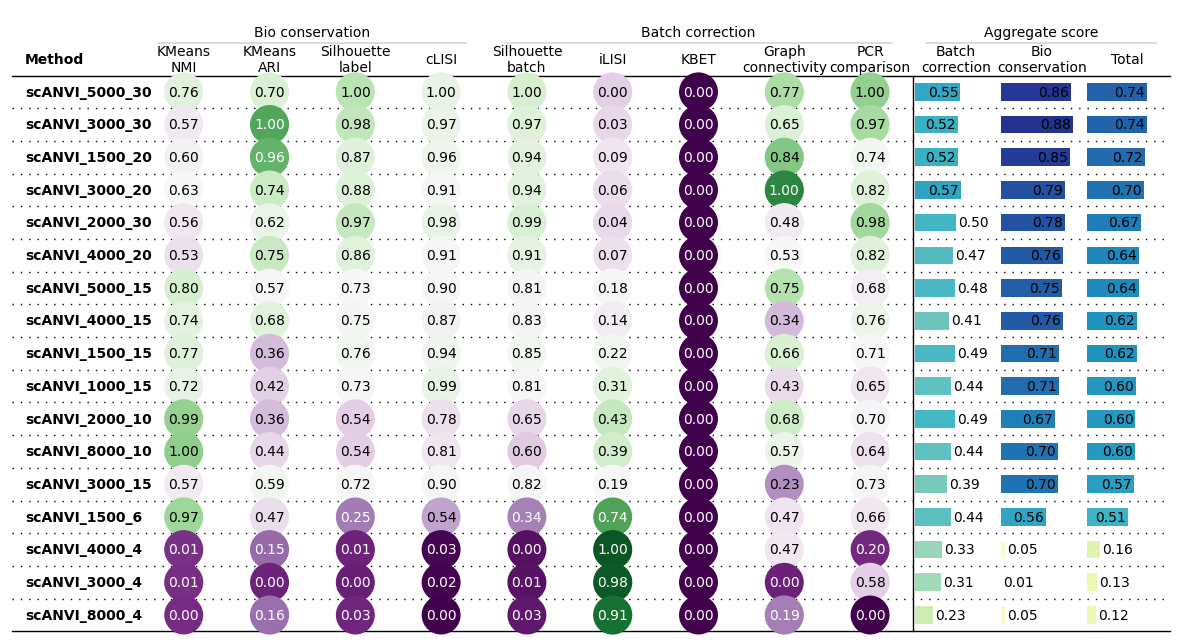

<Figure size 640x480 with 0 Axes>

In [21]:
bm.plot_results_table()
matplotlib.pyplot.savefig("../../results/preIntergration/20241018_hyperpara/20241019_grid_hypertune_metric.pdf")